This notebook presents three analyses related to the autocorrelation structure of mortality rasters:
 - Is spatial or temporal autocorrelation stronger?
 - Over what length scales is spatial autocorrelation observed?
 - How does the strength of spatial autocorrelation decline with increasing spatial lag?

In [1]:
%%capture
!pip install scikit-gstat xarray-spatial

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import skgstat as skg
import xrspatial

import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

## Prepare data

We only care about the damage rasters here so we can just get that variable.

In [3]:
ds = xr.open_dataset("mort_datasets/westmort.nc").sel(time=slice(2001, None))

mort = ds.mortality.where(ds.treecover > 10)
gfw  = ds.gfw_damage.where(ds.treecover > 10)

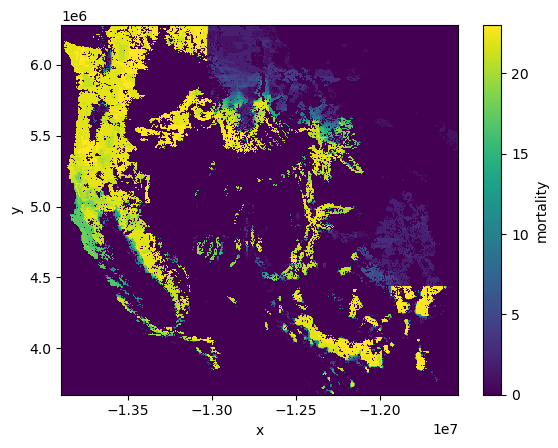

In [4]:
# Plot the number of non-NA cells in each pixel
mort.notnull().sum(dim="time").plot()

### Global autocorrelation coefficients

In [5]:
moore_kernel = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
])

@xrspatial.utils.ngjit
def decorated_nanmean(kernel_data):
    return np.nanmean(kernel_data)

def focal_2d(arr):
    return xrspatial.focal.apply(
        xr.DataArray(arr),
        moore_kernel,
        func=decorated_nanmean,
        name="focal_mean"
    )
    
spatial_lag  = xr.apply_ufunc(
    focal_2d,
    mort,
    input_core_dims=[["y", "x"]],
    output_core_dims=[["y", "x"]],
    vectorize=True
)

temporal_lag = mort.shift(time=1)

In [6]:
def masked_array_correlation(a1, a2):
    a1_flat = a1.flatten()
    a2_flat = a2.flatten()
    
    mask = (~np.isnan(a1_flat)) & (~np.isnan(a2_flat))

    return np.corrcoef(a1_flat[mask], a2_flat[mask])[0, 1]

spat_ac = masked_array_correlation(
    spatial_lag.isel(time=slice(1, None)).values, 
    mort.isel(time=slice(1, None)).values
)
temp_ac = masked_array_correlation(
    temporal_lag.isel(time=slice(1, None)).values,
    mort.isel(time=slice(1, None)).values
)

print(f"Global Temporal AC(1): {temp_ac:.3f}")
print(f"8-neighborhood Spatial AC: {spat_ac:.3f}")

Global Temporal AC(1): 0.392
8-neighborhood Spatial AC: 0.791


### Multiple temporal lags

Text(0, 0.5, 'Pearson correlation coefficient')

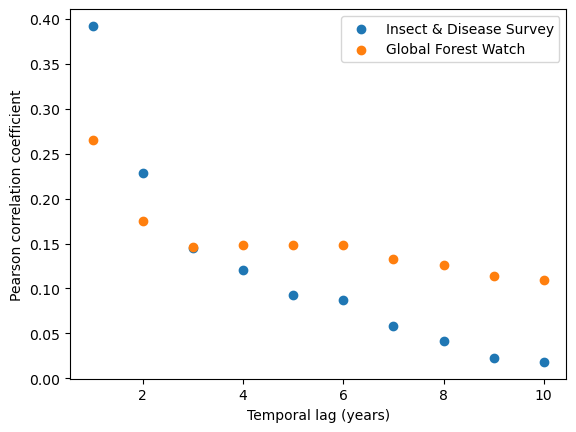

In [7]:
# Try several temporal lags
def get_temporal_lags(data, n_lags):
    temporal_cors = np.zeros(n_lags)
    
    for i in range(n_lags):
        this_lag = data.shift(time=i+1)
        temporal_cors[i] = masked_array_correlation(
            this_lag.isel(time=slice(i+1, None)).values,
            data.isel(time=slice(i+1, None)).values
        )

    return temporal_cors

n_t_lags = 10
mort_temporal_cors = get_temporal_lags(mort, n_t_lags)
gfw_temporal_cors  = get_temporal_lags(gfw, n_t_lags)

plt.scatter(np.arange(n_t_lags)+1, mort_temporal_cors, label="Insect & Disease Survey")
plt.scatter(np.arange(n_t_lags)+1, gfw_temporal_cors, label="Global Forest Watch")
plt.legend()
plt.xlabel("Temporal lag (years)")
plt.ylabel("Pearson correlation coefficient")

### Multiple spatial lags

This is a "running" calculation of Moran's I. As in, we calculate components of the formula for each time step and then combine these together at the end. The inner for loop indexes different spatial lags, which lets us only calculate the distance matrix once for each time step. The formula for Moran's I is

$$
I = \frac{N}{W} \frac{\sum_{i}\sum_{j} w_{ij}(x_i-\bar{x})(x_j-\bar{x})}{\sum{(x-\bar{x})^2}}
$$

where $W$ is the sum of all weights $w_{ij}$, and N is the number of unique $x$. We can modify this formula to suit our problem by saying that $w_{ij} = 0$ for $i, j$ that index different time steps. Further, $w_{ij} = 0$ for pixels $i, j$ that are outside of a distance range we provide through the `lags` parameter. This lets us calculate, for example, Moran's I for pixels that are separated by between 5 and 10 km. Since we do not consider pixel pairs from different time steps, we can iterate over each slice in time and track four running sums:

 - $N_t$, the number of unique pixels involved in the calculation at time $t$.
 - $W_t$, the sum of weights at time $t$.
 - $\sum_i\sum_j{w_{ij}(x_i-\bar{x})(x_j-\bar{x})}$.
 - $\sum{(x-\bar{x})^2}$

Here, $\bar{x}$ is not the same as the global mean because some pixels may not have any valid pairs for a given spatial lag. However, $\bar{x}$ is reasonably approximated by the global mean and knowing this value ahead of time greatly simplifies calculation. This assumption does not hold as well for the sum of squares term in the denominator this value is affected by the number of valid cells in the calculation. This is why we include a running sum of squares but not a running global mean.

In [8]:
from tqdm.autonotebook import tqdm
from scipy import sparse
from scipy.spatial import cKDTree as KDTree

max_distance_bt_pixels = 17

def moranI_at_lags(data, lags):
    global_mean = np.nanmean(data.values)

    # These statistics are calculated for every spatial
    # lag we consider.
    running_wij = np.zeros(lags.shape[0]-1)
    running_n   = np.zeros(running_wij.shape)
    running_w   = np.zeros(running_wij.shape)
    running_ssq = np.zeros(running_wij.shape)

    for ti in tqdm(range(data.sizes["time"])):
        # Identify usable points
        data_t = data.isel(time=ti)
        coords = np.stack(np.where(data_t.notnull())).T
        # Select values at this coordinate
        y_da = xr.DataArray(coords[:, 0], dims="sample")
        x_da = xr.DataArray(coords[:, 1], dims="sample")
        values = data_t.isel(y=y_da, x=x_da).values.T
        # Build distance matrix
        tree = KDTree(coords)
        mtx = tree.sparse_distance_matrix(tree, max_distance_bt_pixels, p=2.0, output_type="ndarray")
        for li in range(lags.shape[0]-1):
            # Get limits for this lag
            lag_low  = lags[li]
            lag_high = lags[li+1]

            # Subset distance matrix & values
            dist_mask = (mtx["v"] > lag_low) & (mtx["v"] <= lag_high)
            xi = values[mtx["i"][dist_mask]]
            xj = values[mtx["j"][dist_mask]]
            w_t  = 1/(mtx["v"][dist_mask])
            
            unique_ij = np.unique(np.concatenate((mtx["i"], mtx["j"])))
            n_t = unique_ij.shape[0]
            ssq_t = np.sum((values[unique_ij] - global_mean) ** 2)
                           
            wij_sum = np.sum(w_t * (xi - global_mean) * (xj - global_mean))

            running_wij[li] += wij_sum
            running_n[li]   += n_t
            running_w[li]   += np.sum(w_t)
            running_ssq[li] += ssq_t

    # Calculate Moran's I for each lag.
    I = (running_n / running_w) * (running_wij / running_ssq)

    return I

In [9]:
pixel_size_km = 4
lags = np.linspace(4, 60, num=11) / pixel_size_km

ads_I = moranI_at_lags(mort, lags)

  0%|          | 0/23 [00:00<?, ?it/s]

In [10]:
gfw_I = moranI_at_lags(gfw, lags)

  0%|          | 0/23 [00:00<?, ?it/s]

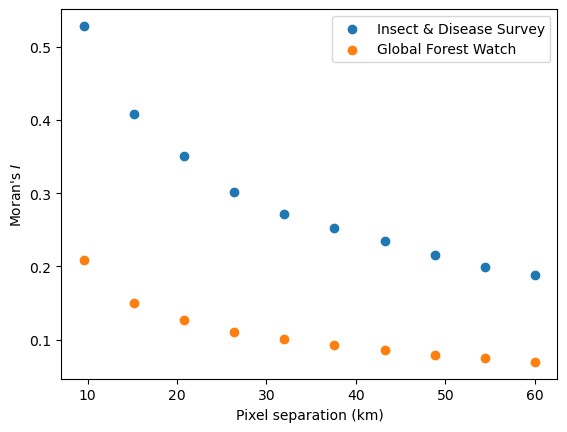

In [11]:
plt.scatter(lags[1:]*pixel_size_km, ads_I, label="Insect & Disease Survey")
plt.scatter(lags[1:]*pixel_size_km, gfw_I, label="Global Forest Watch")
plt.legend()
plt.ylabel("Moran's $I$")
plt.xlabel("Pixel separation (km)")
plt.show()

In [12]:
import pandas as pd

pd.DataFrame({
    "spatial_lag_km": lags[1:]*pixel_size_km,
    "ads_I": ads_I,
    "gfw_I": gfw_I
}).to_csv("data_out/morans_I.csv")

pd.DataFrame({
    "temporal_lag_yrs": np.arange(n_t_lags)+1,
    "ads_r": mort_temporal_cors,
    "gfw_r": gfw_temporal_cors
}).to_csv("data_out/temporal_r.csv")

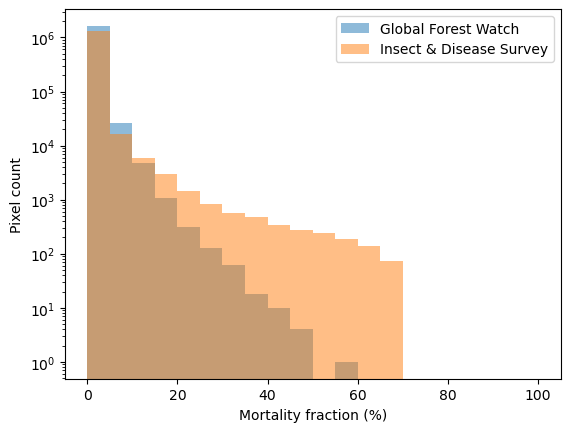

In [13]:
fig, ax = plt.subplots()

edges = np.arange(0, 101, step=5)

gfw.plot.hist(yscale="log", bins=edges, label="Global Forest Watch", ax=ax, alpha=0.5)
mort.plot.hist(bins=edges, label="Insect & Disease Survey", ax=ax, alpha=0.5)

plt.xlabel("Mortality fraction (%)")
plt.ylabel("Pixel count")
plt.legend()
plt.show()

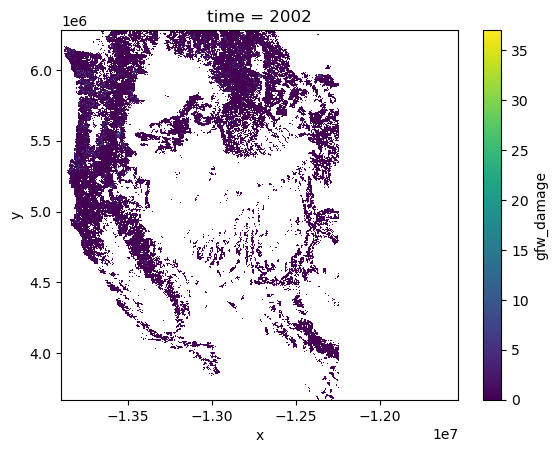

In [14]:
gfw.isel(time=1).plot()